# Predictions ML Project

This ML Project uses one week's worth of Prediction Analyzer predictions and vehicle_events as source data. The data has some potential ML features like the stop_id, route_id, timestamp, etc, as well as the predictions we made and the observed times of the actual arrival and departure events. This data was chosen because there's a lot of it and it's easy to obtain, and therefore a good way to test out the ML process, not because we expected particularly great results.

## Obtaining the data

The data is available in a public S3 bucket, about 140MB zipped and about 1GB unzipped, and about 7 million rows altogether. The following code downloads it (if it detects it doesn't exist already) to a `datasets/` directory. It then reads it into a Pandas DataFrame called `pristine_data` and makes a copy of it called `data`. Since it takes some time to unzip the file and read it into memory, we always work on `data`, and if we want to scrap our changes and start over, we can re-run all the cells, and it will copy over `data = pristine_data.copy()` once again.

In [1]:
import pandas as pd
import numpy as np

In [2]:
import os
from pathlib import Path
from six.moves import urllib

DOWNLOAD_URL = "https://s3.amazonaws.com/mbta-subway-realtime/datasets/predictions.csv.gz"
LOCAL_DIR = os.path.join("datasets")
LOCAL_FILE = os.path.join(LOCAL_DIR, "predictions.csv.gz")

def fetch_predictions_data():
    if not os.path.isdir(LOCAL_DIR):
        os.makedirs(LOCAL_DIR)
        
    if not os.path.isfile(LOCAL_FILE):
        print("Downloading predictions.csv.gz")
        urllib.request.urlretrieve(DOWNLOAD_URL, LOCAL_FILE)
        print("Downloaded.")

def load_predictions_data():
    return pd.read_csv(
        LOCAL_FILE, 
        dtype={"predictions_route_id": str, "predictions_stop_id": str},
        compression='gzip'
    )

In [3]:
try:
    pristine_data
except NameError:
    fetch_predictions_data()
    pristine_data = load_predictions_data()

data = pristine_data.copy()

In [4]:
data.head()

,predictions_id,predictions_trip_id,predictions_arrival_time,predictions_boarding_status,predictions_departure_time,predictions_stop_id,predictions_stop_sequence,predictions_stops_away,predictions_vehicle_event_id,predictions_file_timestamp,predictions_route_id,predictions_vehicle_id,predictions_direction_id,ve_id,ve_arrival_time,ve_departure_time
0,648187443,39783376,1.553863e+09,NaN,1.553863e+09,70040,10,1.0,10212508,1553862833,Blue,B-545C365A,1,10212508,1.553863e+09,1.553863e+09
1,648187455,39988585-20:30-FKenmoreStMaryC,1.553863e+09,NaN,1.553863e+09,70203,620,1.0,10212521,1553862833,Green-C,G-10142,1,10212521,1.553863e+09,1.553863e+09
2,648187514,40033949,1.553864e+09,NaN,1.553864e+09,70007,30,8.0,10214673,1553862833,Orange,O-545C36A0,1,10214673,1.553864e+09,1.553864e+09
3,648187604,ADDED-1553782585,1.553864e+09,NaN,1.553864e+09,70156,580,9.0,10214713,1553862833,Green-D,G-10152,1,10214713,1.553864e+09,1.553864e+09
4,648187732,40033948,1.553863e+09,NaN,1.553863e+09,70005,20,2.0,10213047,1553862833,Orange,O-545C364E,1,10213047,1.553863e+09,1.553863e+09


## Preparing the data

There are a variety of ways to clean up the data. Some things we need to take care of: handle null values and remove outliers.

### Restrict the size

Some algorithms (in particular, Random Forest and SVM) can't seem to handle our 7 million rows very well. Linear regression, on the other hand is able to train in just a couple minutes on the entire dataset. We often restrict the data to just a certain route, for perforamnce reasons, but also because they behave rather differently, and fitting  all of them might not be the best approach anyway. Depending on whether and how you want to restrict the data, adjust or comment out the following line.

In [5]:
data = data[data["predictions_route_id"] == 'Mattapan']

### Arrivals vs. Departures and handling nulls

Not all predictions have both arrivals and departures. We don't predict a departure for the last stop on a trip, and conversely we don't predict an arrival for the first.

In addition, at terminals beginning a route we use the departures: ("The next train to Braintree departs in 4 minutes"). At stations along a route we use arrivals: ("The next train to Braintree arrives in 4 minutes").

For this investigation we decided to focus on arrival times, and so removed any rows with NULL arrivals, as well as arrival predictions for more than 30 minutes away or earlier than 30 seconds ago (train sitting at platform), which we don't score ourselves on with the Prediction Analyzer.

In [6]:
data = data.dropna(subset=["predictions_arrival_time", "ve_arrival_time"])
data = data[data["predictions_arrival_time"] - data["predictions_file_timestamp"] < 30*60]
data = data[data["predictions_arrival_time"] - data["predictions_file_timestamp"] > -30]

### Predicting our error

There's different approaches to what our labels (and therefore ML-predicted values) could be. We could try to directly predict the arrival times, but with this dataset we likely don't have enough features (e.g. where the trains are or where they're going) to do a great job of it.

Instead, what we'll do is calculate the _error_ we made in our own predictions, and then see if an ML model can do a good job of predicting that error. This would imply a persistent bias in how RTR makes predictions, and that accuracy could be improved by either fixing that bias or even just running the predictions through the ML-model to adjust them.

We also throw out rows with very large errors as those tend to be from unanticipated incidents that can't be predicted well anyway.

In [7]:
data["predictions_error"] = data["ve_arrival_time"] - data["predictions_arrival_time"]
data = data[data["predictions_error"] >= -600]
data = data[data["predictions_error"] <= 600]

Let's take a look at the prediction errors we make:

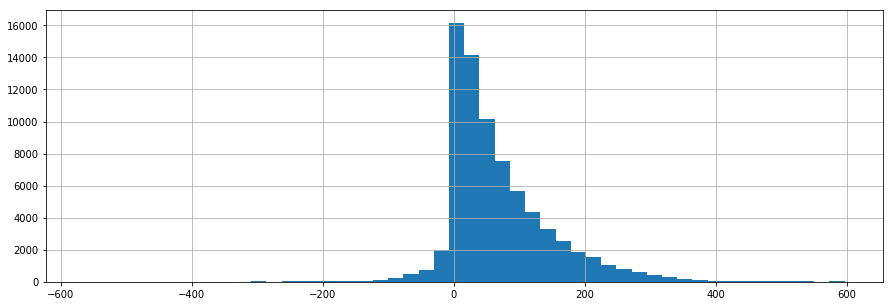

In [8]:
%matplotlib inline
import matplotlib.pyplot as plt
data["predictions_error"].hist(bins=50, figsize=(15,5))
plt.show()

### Set aside a test set

Before doing any serious investigation or further modifications to the data for different algortihms, we should set aside a test set.

We use a `StratifiedShuffleSplit` to ensure that the randomly selected training and test sets have the same proportion of data in each route.

In [9]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(data, data["predictions_route_id"]):
    strat_train_set = data.iloc[train_index]
    strat_test_set = data.iloc[test_index]
    
train_labels = strat_train_set["predictions_error"].copy()
test_labels = strat_test_set["predictions_error"].copy()

## Data Transformations

Different algorithms call for transforming the data in different ways. For example, SVMs should have their features standardized and centered. Or linear regressions can't handle unix epoch file timestamps well, and work better with discretizing them into time window bins.

Scikit-learn aids these transformations with the concept of a "Pipeline" that you run your data through. It provides Transformers and also allows you to write your own to fit into the pipeline. This makes it quite easy to fiddle with the pipeline, the transformers, and the characteristics of the transformers ("hyperparameters").

To write your own Transformer you write a class that inherits from Scikit-learn's classes, and provide three methods. You can use the constructor, `__init__` to present hyperparameters for the user to tune. `fit` sets internal state based on the data (e.g. this is where a learning algorithm would train), and `transform` takes the data as an argument and returns a _new copy_ of the transformed data.

### `IsStoppedTransformer`

This transformer checks the `predictions_boarding_status` column, which can be either NULL or something like "Stopped 4 stops away", and generates a boolean feature `is_stopped` from it.

In [10]:
from sklearn.base import BaseEstimator, TransformerMixin

class IsStoppedTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        result = X.copy()
        result['is_stopped'] = X['predictions_boarding_status'].notnull()
        return result.drop('predictions_boarding_status', axis=1)

### `TimestampTransformer`

This transformer takes the `predictions_file_timestamp` value, which is a UNIX epoch value, and sets two columns: a `predictions_day_of_week` (from 0 = Monday to 6 = Sunday), and `predictions_time_bin`, which starts at `0` at midnight and increments for every 15 minuts. E.g., a prediction at 11:35AM would be `46`.

In [11]:
from sklearn.base import BaseEstimator, TransformerMixin
from datetime import datetime

class TimestampTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        new_data = X.copy()
        datetimes = new_data['predictions_file_timestamp'].apply(
            lambda x: datetime.fromtimestamp(x),
        )
        predictions_day_of_week = datetimes.apply(lambda x: x.weekday())
        predictions_time_bin = datetimes.apply(self._timestamp_bin)
        new_data['predictions_day_of_week'] = predictions_day_of_week
        new_data['predictions_time_bin'] = predictions_time_bin
        return new_data
    
    def _timestamp_bin(self, timestamp):
        return timestamp.hour * 4 + timestamp.minute // 15

### `AccuracyBinTransformer`

This takes the difference of `predictions_arrival_time` and `predictions_file_timestamp` UNIX times (which gives the predicted number of seconds "from now" that the train will arrive), and bins it according to the groupings that drive the MBTA's accuracy data: "0-3 minutes", "3-6 minutes", "6-12 minutes", and "12-30 minutes".

In [12]:
from sklearn.base import BaseEstimator, TransformerMixin

class AccuracyBinTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        copy = X.copy()
        copy["accuracy_bin"] = (copy['predictions_arrival_time'] - copy['predictions_file_timestamp']).apply(self._accuracy_bin)
        return copy
        
    def _accuracy_bin(self, seconds):
        if seconds < -30:
            return 'na-'
        elif -30 <= seconds < 180:
            return '0-3'
        elif 180 <= seconds < 360:
            return '3-6'
        elif 360 <= seconds < 720:
            return '6-12'
        elif 720 <= seconds < 1800:
            return '12-30'
        else:
            return 'na+'

### Other transformers

We wrote a `DebugTransformer` that simply prints a bit of the data and returns it unchanged. This is an easy way to get a peek at what's going on with the data through the pipeline.

We also wrote a `DenseMatrixTransformer` which just calls `.toarray()` on the data it gets. This has the effect of converting a sparse matrix (which you often get after One Hot encoding a feature) into a dense one, which is required by the SVM algorithm.

In [13]:
from sklearn.base import BaseEstimator, TransformerMixin

class DebugTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        print(X.info())
        return X

class DenseMatrixTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        return X.toarray()

### Putting it together in a Pipeline

You can now put together these transformers in a pipeline.

In addition to our custom transformers, we use some built-in ones:

* `ColumnTransformer` - this runs its transformers in parallel, passing a specified subset of columns to each one, and then concatenates the results.
* `passthrough` - this enumerates the set of columns the `ColumnTransformer` should "pass through" untouched to the output. It serves as a whitelist of columns to allow in the final data set.
* `OneHotEncoder` - this will transform one column of N unique values into N columns, representing each of those values. Each row will then have a `1` in the column corresponding to the value it used to have, and `0` in all the others. In the `ColumnTransformer` we specify which of our input columns we want to have this done to.
* `PolynomialFeatures` - this will, depending on its configuration, multiply the features together in various ways, which is an easy way to allow a linear algorithm (e.g. linear regression) to handle non-linear relationships between features.
* `StandardScaler` - this scales the features to have a mean of zero and variance of one.

In [14]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import PolynomialFeatures, StandardScaler, OneHotEncoder

passthrough_features = [
    'is_stopped',
    'predictions_stops_away',
#     'predictions_direction_id'  # highly correlated with stop_id
]

column_transformer = ColumnTransformer([
    ('pass', 'passthrough', passthrough_features),
    ('1hot', OneHotEncoder(), [
        'predictions_stop_id', 
#         'predictions_route_id', # can't use this if dataset is restricted to one route_id
        'predictions_day_of_week',
        'accuracy_bin',
        'predictions_time_bin'
    ])
])

predictions_pipeline = Pipeline([
    ('timestamp', TimestampTransformer()),
    ('is_stopped', IsStoppedTransformer()),
    ('accuracy_bin', AccuracyBinTransformer()),
    ('col_transformer', column_transformer),
#     ('poly', PolynomialFeatures(degree=2)),  # takes too long when stop_ids are one-hotted
#     ('dense_matrix', DenseMatrixTransformer()), # necessary when using StandardScaler
#     ('std_scaler', StandardScaler()),
])

## Train the data!

And now the fun begins.

With the pipeline in place, and easily tweakable, we can run train different learning algorithms on it, and then visualize their results.

In [15]:
transformed_data = predictions_pipeline.fit_transform(strat_train_set)

Set the `algo` variable to which one this notebook should run when clicking "Run All".

In [16]:
algo = 'random_forest'  # can change to 'random_forest' or 'svm'

### Linear regression

The fastest algorithm is a simple linear regression. It also has the benefits of having easily interpretable results. It's always a good place to start.

In [17]:
from sklearn.linear_model import LinearRegression

if algo == 'linear_regression':
    lin_reg = LinearRegression()
    lin_reg.fit(transformed_data, train_labels)
    predictions = lin_reg.predict(transformed_data)

One easy way to see how well the model worked is its root mean squared error:

In [18]:
from sklearn.metrics import mean_squared_error

if algo == 'linear_regression':
    lin_mse = mean_squared_error(train_labels, predictions)
    lin_rmse = np.sqrt(lin_mse)
    print(lin_rmse)

And we can see the model's bias (intercept):

In [19]:
if algo == 'linear_regression':
    lin_reg.intercept_

and its coefficients:

In [20]:
if algo == 'linear_regression':
    ct = predictions_pipeline.named_steps['col_transformer']
    (_, _, passthrough_cols) = ct.transformers[0]
    onehot_cols = ct.named_transformers_['1hot'].get_feature_names()

    features = passthrough_cols + onehot_cols.tolist()
    sorted(zip(lin_reg.coef_, features))

### Random forest

This algorithm was tolerable to train on a single route, but not on the whole dataset. And it gave very good results, albeit not ones that are interpretable.

In [22]:
from sklearn.ensemble import RandomForestRegressor

if algo == 'random_forest':
    rand_forest = RandomForestRegressor(n_estimators=10, n_jobs=8)
    rand_forest.fit(transformed_data, train_labels)
    predictions = rand_forest.predict(transformed_data)

In [25]:
from sklearn.metrics import mean_squared_error

if algo == 'random_forest':
    forest_mse = mean_squared_error(train_labels, predictions)
    forest_rmse = np.sqrt(forest_mse)
    print(forest_rmse)

33.348265674445706


In [26]:
if algo == 'random_forest':
    ct = predictions_pipeline.named_steps['col_transformer']
    (_, _, passthrough_cols) = ct.transformers[0]
    onehot_cols = ct.named_transformers_['1hot'].get_feature_names()

    features = passthrough_cols + onehot_cols.tolist()

    sorted(zip(rand_forest.feature_importances_, features))

### Support vector machines

SVMs can be used as a classifier or a regressor (SVR in that case), and can use a linear or polynomial (or other) kernel.

In our testing, we couldn't get it to complete other than with a very small data set (e.g. Mattapan, but no other route).

In [27]:
from sklearn.svm import LinearSVR

if algo == 'svm':
    lsvm = LinearSVR(epsilon=0, dual=False, loss='squared_epsilon_insensitive')
    lsvm.fit(fitted, train_labels)
    predictions = lsvm.predict(fitted)

In [28]:
from sklearn.metrics import mean_squared_error

if algo == 'svm':
    lsvm_mse = mean_squared_error(train_labels, predictions)
    lsvm_rmse = np.sqrt(lsvm_mse)
    lsvm_rmse

In [29]:
if algo == 'svm':
    ct = predictions_pipeline.named_steps['col_transformer']
    (_, _, passthrough_cols) = ct.transformers[0]
    onehot_cols = ct.named_transformers_['1hot'].get_feature_names()

    features = passthrough_cols + onehot_cols.tolist()

    sorted(zip(lsvm.coef_, features))

Or with a polynomial kernel

In [30]:
from sklearn.svm import SVR

if algo == 'svm':
    svm_poly_reg = SVR(kernel="poly", degree=2, epsilon=30)
    svm_poly_reg.fit(fitted, train_labels)

## Visualize the results

Finally, let's look at the results of the model. Since we were predicting the error of our predictions, we can generate New and Improved™ (hopefully) predictions, by predicting an error for each row and adding it to the existing prediction.

We can then score each row as "accurate" or not for the original prediction and the ML-adjusted prediction, according to the tolerances we use in the Prediction Analyzer, and then chart our accuracy rates.

We should choose if we want to do this against our `strat_training_set` (the data we trained against, to visualize it), or `strat_test_set` (the data we held out at the beginning, to see our final results).

In [31]:
viz_data = strat_train_set.copy()  # or strat_test_set.copy()

In [32]:
if algo == 'linear_regression':
    model = lin_reg
elif algo == 'random_forest':
    model = rand_forest
elif algo == 'svm':
    model = lsvm

In [33]:
transformed_viz_data = predictions_pipeline.fit_transform(viz_data)
predicted_errors = model.predict(transformed_viz_data)
viz_data = AccuracyBinTransformer().transform(viz_data)
viz_data["ml_arrival_time"] = viz_data.loc[:, "predictions_arrival_time"] + predicted_errors
viz_data["ml_error"] = viz_data.loc[:, "ve_arrival_time"] - viz_data.loc[:, "ml_arrival_time"]

We can also compare the RMSE of the original data to our adjusted data.

In [34]:
import numpy as np

predictions_rmse = np.sqrt(viz_data["predictions_error"].apply(lambda x: x**2).sum() / len(viz_data["predictions_error"]))
ml_rmse = np.sqrt(viz_data["ml_error"].apply(lambda x: x**2).sum() / len(viz_data["ml_error"]))
(predictions_rmse, ml_rmse)

(107.68942336443116, 33.348265674231435)

In [35]:
def is_accurate(acc_bin, error):
    if acc_bin == '0-3':
        return -60 <= error <= 60
    elif acc_bin == '3-6':
        return -90 <= error <= 120
    elif acc_bin == '6-12':
        return -150 <= error <= 210
    elif acc_bin == '12-20':
        return -240 <= error <= 360
    else:
        return False

def is_accurate_vector(acc_bins, errors):
    return (acc_bins.str.match('0-3') & (errors >= -60) & (errors <= 60)) | \
        (acc_bins.str.match('3-6') & (errors >= -90) & (errors <= 120)) | \
        (acc_bins.str.match('6-12') & (errors >= -150) & (errors <= 210)) | \
        (acc_bins.str.match('12-30') & (errors >= -240) & (errors <= 360))

In [36]:
viz_data["ml_accuracy"] = is_accurate_vector(viz_data["accuracy_bin"], viz_data["ml_error"])
viz_data["prediction_accuracy"] = is_accurate_vector(viz_data["accuracy_bin"], viz_data["predictions_error"])

Depending on how the data was limited, you may want to group by `prediction_stop_id` instead of `predictions_route_id`:

In [37]:
pred_acc = viz_data.groupby('predictions_route_id')['prediction_accuracy'].mean()

In [38]:
ml_acc = viz_data.groupby('predictions_route_id')['ml_accuracy'].mean()

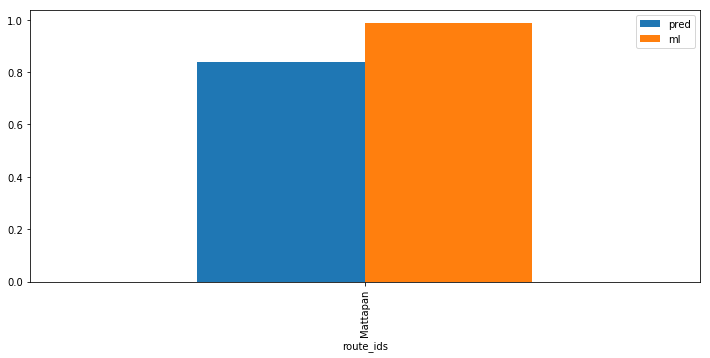

In [39]:
pd.DataFrame({
    'route_ids': ml_acc.index.values, 
    'pred': pred_acc.values, 
    'ml': ml_acc.values
}).plot(kind='bar', x='route_ids', figsize=(12,5))
